<a href="https://colab.research.google.com/github/ClockisTicking/My_Work_at_HF/blob/main/Text_embedding_for_Multi_Modal_Machine_Learning%2C_TF_IDF_VS_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text embedding for Multi-Modal Machine Learning, TF-IDF VS Transformer**

This notebook compares the tradition TF-IDF approach VS transformer as text feature extaction methods used in multi-modal machine learning. The dataset we will be using for this demo is "Women's E-Commerce Clothing Reviews", the dataset's kaggle page can be found [here](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

For the sake of comparison, We will be using the follow achetecture for both Transformer and TF-IDF:
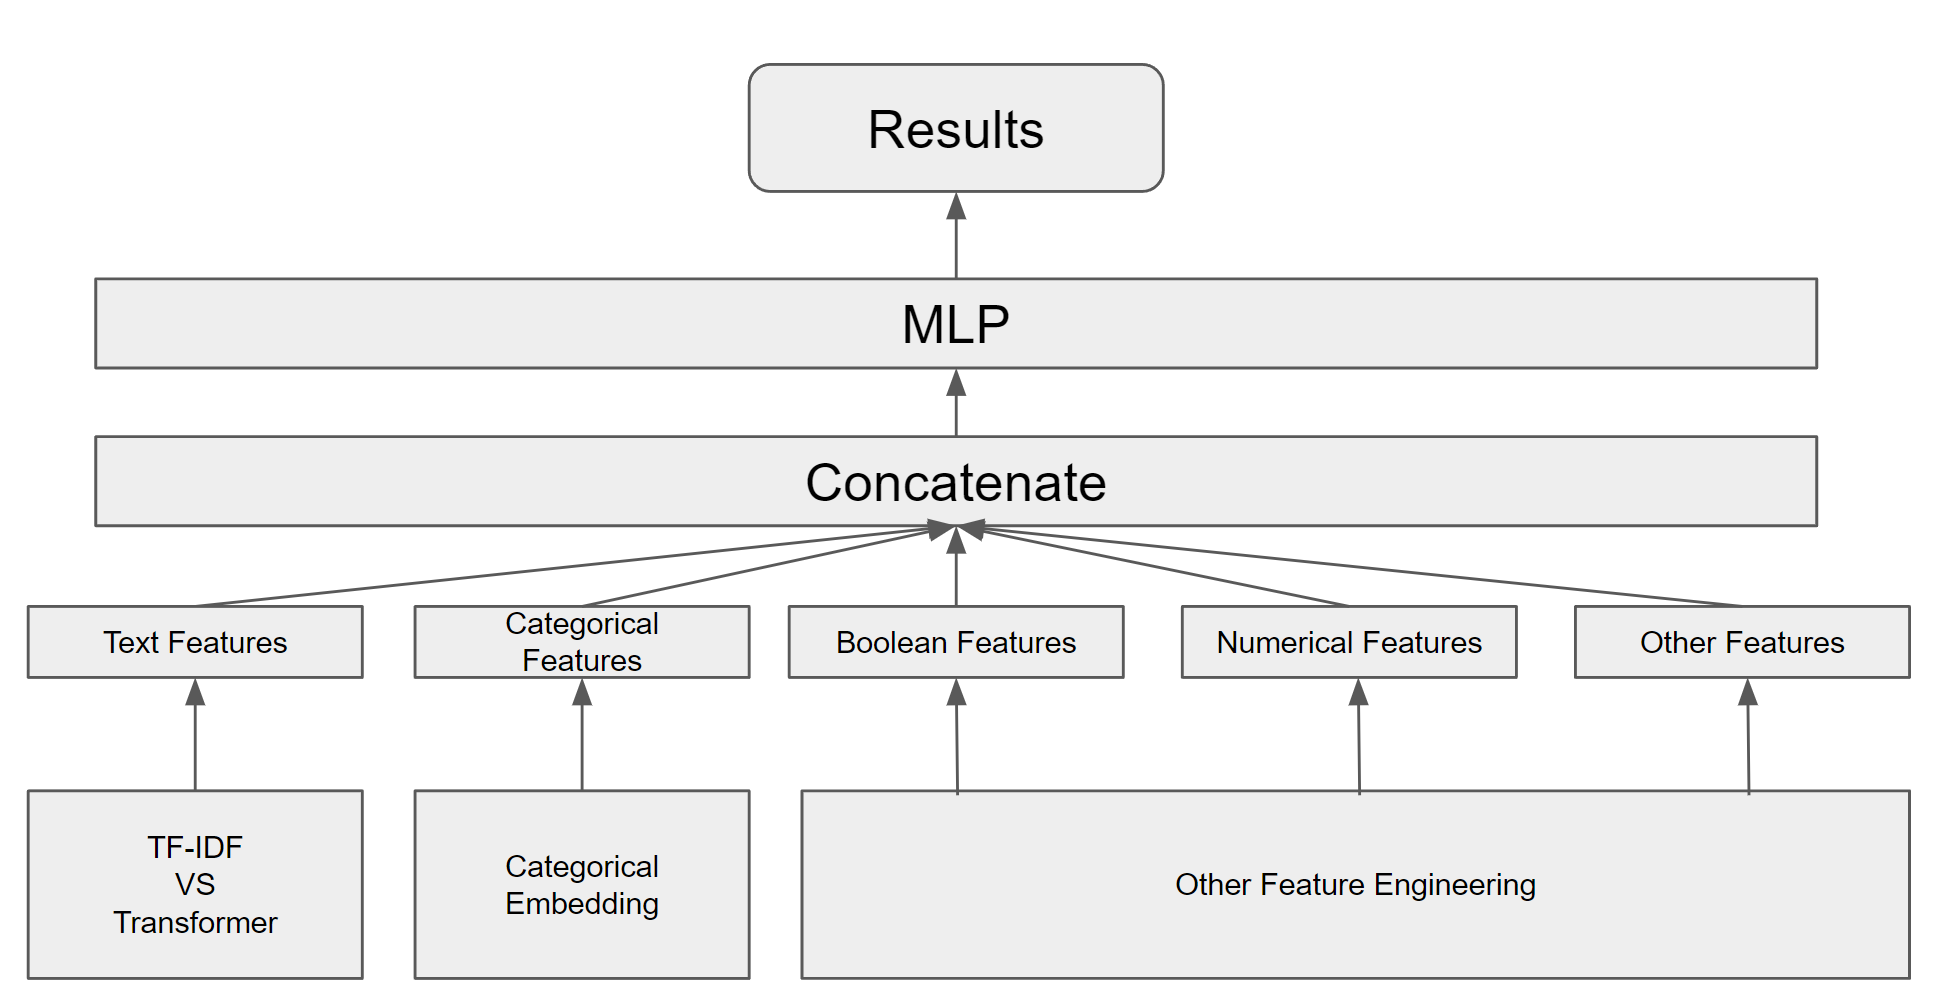

We will compare and contrast TF-IDF and Transformer as text embedder, while keeping the rest the same.

Notice that we will be using both TF-IDF and transformer in its simplest form. We do know lots of tricks to work with both TF-IDF and transformers, but we choose not to use them for the sake of raw comparison.

Since the main focus is on comparison rather than raw meterics, we will be using a Train/Val data split instead of a Train/Dev/Test split.

We will not be normalizing the numerical attributes since they are just counts.

We will keep track of serval metrics, and log the best of them across all checkpoints. The reason for this is, in reality, we might just care about one of them, so providing the best posible value for all the metrics is more helpful than just the metrics of the best checkpoint.  

First, let's take a look at the dataset. Notice the detailed statistics can be found on the [dataset's Kaggle page](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews), taking a look before continuing would be helpful, since we will only show a breif summary here.

### **The Dataset**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
dataset_url = "https://raw.githubusercontent.com/georgian-io/Multimodal-Toolkit/master/datasets/Womens_Clothing_E-Commerce_Reviews/Womens%20Clothing%20E-Commerce%20Reviews.csv"

In [ ]:
# read the dataset into dataframe and drop NAN
dataset_csv = pd.read_csv(dataset_url, index_col=[0])
print("Raw dataset size: {size}".format(size = len(dataset_csv)))
dataset_csv = dataset_csv.dropna().reset_index(drop = True)
print("None-NAN dataset size: {size}".format(size = len(dataset_csv)))

Raw dataset size: 23486
None-NAN dataset size: 19662


In [ ]:
dataset_csv.head(6)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
5,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits


As we can see, the dataset contains quite a few NAN inputs. There are lots of ways we can fill the missing values, but for the sake of this demo, we will drop all rows containing a NAN so we have a completely dense dataset free of artificial fillers to compare our methods with.


We will use the `Recommended IND` attribute as our label, so we have a classic binary classification problem. Also, the "`Clothing ID`" attribute provide 0 information regarding the label, so we will not be including this column.


We will be dropping the "`Rating`" column as well, since this attribute provides too much information regarding the label, it would render the problem trival.




In [ ]:
dataset_csv.drop(columns = ['Clothing ID', 'Rating'], inplace = True)

In [ ]:
dataset_csv.head(6)

,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,60,Some major design flaws,I had such high hopes for this dress and reall...,0,0,General,Dresses,Dresses
1,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,0,General Petite,Bottoms,Pants
2,47,Flattering shirt,This shirt is very flattering to all due to th...,1,6,General,Tops,Blouses
3,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",0,4,General,Dresses,Dresses
4,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,1,General Petite,Tops,Knits
5,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",1,4,General Petite,Tops,Knits


In [ ]:
labels = dataset_csv["Recommended IND"].tolist()

In [ ]:
print("number of 0 labels: {zeros}".format(zeros = labels.count(0)))
print("number of 1 labels: {ones}".format(ones = labels.count(1)))

number of 0 labels: 3575
number of 1 labels: 16087


As we can see this is not a very balanced dataset, we will be using accuracy, F1 score, precision and recall as metrics.

### **The MLP**

We use a standard MLP for classification. A dense layer followed by a half sized layer and then the classification output

In [ ]:
import torch
import torch.nn as nn

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)

def get_classifier(input_size, output_size = 2):
    # since we will be using this classifier for different text encoding methods, we will make the input size flexible. output size is default to 2 since this is a binary classification problem
    mlp = nn.Sequential(
                nn.Linear(in_features = input_size, out_features = input_size, bias = True), # Dense linear transformation
                nn.BatchNorm1d(input_size),
                nn.ReLU(),
                nn.Dropout(p = 0.1, inplace = False),
                nn.Linear(in_features = input_size, out_features = input_size // 2, bias = True),
                nn.BatchNorm1d(input_size // 2),
                nn.ReLU(),
                nn.Dropout(p = 0.1, inplace = False),
                nn.Linear(in_features = input_size // 2, out_features = output_size, bias = True),
                nn.Softmax(dim = 1)
            )
    return mlp.apply(weights_init)

## **TF-IDF**

### **Data preprocessing for TF-IDF**

We will use the standard data processing procedue for trandition NLP. which means we will remove all punctuation and special characters, lower-case all the characters, remove all stop words optionally and lemmatize the words.

Given the way TF-IDF works, removing stop work is optional since TF-IDF handles the situation gracefully on its own. We set a variable `remove_stop_word` in the notebook so you can make your own choice.


As standard practice, we will concatenate the Title and the Review Text into a single text feature.

**Standard text preprocessing**

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
remove_stop_word = False

In [ ]:
# tokenize by word, remove anything non-alphanumeric, cast all tokens to lower case, remove stop words and lemmatize the tokens
def preprocess(ls, remove_stop_word):
  res = []
  for item in ls:
    tokens = word_tokenize(item)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    if remove_stop_word:
      tokens = [w for w in tokens if not w in stop_words] # removing stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    res.append(tokens)
  
  return res

In [ ]:
titles = dataset_csv["Title"].tolist()
reviews = dataset_csv["Review Text"].tolist()
processed_titles = preprocess(titles, remove_stop_word)
processed_reviews = preprocess(reviews, remove_stop_word)

In [ ]:
# concatenate the title and reviews with a white space
processed_text = []
for idx, title in enumerate(processed_titles):
  text = title + processed_reviews[idx]
  processed_text.append(" ".join(text))

In [ ]:
# a sample of data after processing
for i in processed_text[:5]:
  print(i)

some major design flaw i had such high hope for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which wa just overall the top half wa comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layer imo a major design flaw wa the net over layer sewn directly into the zipper it c
my favorite buy i love love love this jumpsuit it fun flirty and fabulous every time i wear it i get nothing but great compliment
flattering shirt this shirt is very flattering to all due to the adjustable front tie it is the perfect length to wear with legging and it is sleeveless so it pair well with any cardigan love this shirt
not for the very petite i love tracy reese dress but this one is not for the very petite i am just under 5 foot tall and usually wear a 0p in this brand this dress wa

**Calculate TF-IDF**

In [ ]:
# we use sklearn for this
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [ ]:
tfidf_vectorizer = TfidfVectorizer(use_idf = True) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(processed_text)

In [ ]:
tfidf_embedding_dim = tfidf_vectorizer_vectors.shape[1]
tfidf_vectorizer_vectors

<19662x12546 sparse matrix of type '<class 'numpy.float64'>'
	with 868437 stored elements in Compressed Sparse Row format>

As we can see above we have 19662 rows of data. Depending on our choice to remove stop words or not, we would end up with a vocab size of 12426 or 12546. Since neither are big enough to give us the curse of demensionality, we will just keep it that way for maximum information

**Categorical encoding**

There are many ways to do Categorical encoding, let's first examine the 3 sets of categorical data we have in order to pick a method.

In [ ]:
print("Division Name: {division_name}".format(division_name = dataset_csv["Division Name"].unique().tolist()))
print("Cardinality: {division_name}".format(division_name = len(dataset_csv["Division Name"].unique())))
print("")
print("Department Name: {department_name}".format(department_name = dataset_csv["Department Name"].unique().tolist()))
print("Cardinality: {department_name}".format(department_name = len(dataset_csv["Department Name"].unique())))
print("")
print("Class Name: {class_name}".format(class_name = dataset_csv["Class Name"].unique().tolist()))
print("Cardinality: {class_name}".format(class_name = len(dataset_csv["Class Name"].unique())))

Division Name: ['General', 'General Petite', 'Initmates']
Cardinality: 3

Department Name: ['Dresses', 'Bottoms', 'Tops', 'Intimate', 'Jackets', 'Trend']
Cardinality: 6

Class Name: ['Dresses', 'Pants', 'Blouses', 'Knits', 'Intimates', 'Outerwear', 'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets', 'Swim', 'Trend', 'Jeans', 'Shorts', 'Legwear', 'Layering', 'Casual bottoms', 'Chemises']
Cardinality: 20


As we can see, all categories are non-ordinal, acyclic with low cardinality. Thus, we will use one-hot-encoding for categorical data in our datsets. Other more modern ways of categorical encoding(without transformer) including Word2Vec, Glove and a number of entity embedding methods initially proposed in [this paper](https://arxiv.org/abs/1604.06737). We stick to one-hot-encoding to make everything simple, and concentrate our focus to the comparison of text encoding methods.


In [ ]:
# constructing one-hot-encoding map with python dictionary
def one_hot_mapping(ls):
  one_hot_map = {}
  
  for idx, value in enumerate(ls):
    one_hot = [0] * len(ls)
    one_hot[idx] = 1
    one_hot_map[value] = one_hot
  
  return one_hot_map

division_name_to_one_hot = one_hot_mapping(dataset_csv["Division Name"].unique().tolist())
department_name_to_one_hot = one_hot_mapping(dataset_csv["Department Name"].unique().tolist())
class_name_to_one_hot = one_hot_mapping(dataset_csv["Class Name"].unique().tolist())

In [ ]:
# take a sample
division_name_to_one_hot

{'General': [1, 0, 0], 'General Petite': [0, 1, 0], 'Initmates': [0, 0, 1]}

In [ ]:
# category to one-hot
dataset_csv["Division Name"] = dataset_csv["Division Name"].apply(lambda x : division_name_to_one_hot[x])
dataset_csv["Department Name"] = dataset_csv["Department Name"].apply(lambda x : department_name_to_one_hot[x])
dataset_csv["Class Name"] = dataset_csv["Class Name"].apply(lambda x : class_name_to_one_hot[x])

In [ ]:
# Putting TF-IDF back to the dataset for visualization
array = tfidf_vectorizer_vectors.toarray().tolist()
dataset_csv["tfidf_encoding"] = array
dataset_csv.drop(columns = ["Title", "Review Text"], inplace = True)

In [ ]:
# clean up the memory a bit
del array
del tfidf_vectorizer_vectors
del processed_reviews
del processed_text
del processed_titles
del reviews
del text
del titles

In [ ]:
# make everything look like code
dataset_csv.rename(columns = {"Age" : "age", "Recommended IND": "label", "Positive Feedback Count": "positive_feedback_count", "Division Name" : "division_name", "Department Name" : "department_name", "Class Name" : "class_name"}, inplace = True)

In [ ]:
# the processed dataframe, to be turned into an actual dataset
dataset_csv.head(6)

,age,label,positive_feedback_count,division_name,department_name,class_name,tfidf_encoding
0,60,0,0,"[1, 0, 0]","[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,50,1,0,"[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,47,1,6,"[1, 0, 0]","[0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,49,0,4,"[1, 0, 0]","[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1577544957964..."
4,39,1,1,"[0, 1, 0]","[0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,39,1,4,"[0, 1, 0]","[0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### **Training for TF-IDF**

**Prepare dataset for training**

In [ ]:
! pip install datasets
! pip install transformers
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
batch_size = 128

In [ ]:
def get_dataloaders(dataset, batch_size = batch_size):
    return DataLoader(dataset, shuffle = True, batch_size = batch_size)

In [ ]:
tfidf_dataset = Dataset.from_pandas(dataset_csv).with_format("torch")

In [ ]:
tfidf_dataset

Dataset({
    features: ['age', 'label', 'positive_feedback_count', 'division_name', 'department_name', 'class_name', 'tfidf_encoding'],
    num_rows: 19662
})

In [ ]:
# train/test split
tfidf_split = tfidf_dataset.train_test_split(test_size = 0.1)

In [ ]:
# get dataloader for training
tfidf_train_set = tfidf_split["train"]
tfidf_val_set = tfidf_split["test"]
tfidf_train_loader = get_dataloaders(tfidf_train_set)
tfidf_val_loader = get_dataloaders(tfidf_val_set)

In [ ]:
# clean up some memory, since this is a notebook
del dataset_csv
del tfidf_val_set
del tfidf_train_set
del tfidf_dataset

**The model**

In [ ]:
# the model for training
class build_tfidf_model(nn.Module):
    def __init__(self, input_size, output_size = 2):
        super(build_tfidf_model, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.linear_layers = get_classifier(self.input_size,        
                                            self.output_size)

    def forward(
        self,
        tfidf_encoding = None,
        age = None,
        positive_feedback_count = None,
        division_name = None,
        department_name = None,
        class_name = None
    ):
        # concate inputs for MLP
        mlp_input = torch.cat((tfidf_encoding, age.view(-1, 1), positive_feedback_count.view(-1, 1), division_name, department_name, class_name), 1) 

        logits = self.linear_layers(mlp_input) 
        
        return logits

In [ ]:
input_size = 2 + 3 + 6 + 20 + tfidf_embedding_dim # 2 numerical features, others are one-hot and tfidf

In [ ]:
tfidf_model = build_tfidf_model(input_size = input_size)

In [ ]:
tfidf_model.cuda()

build_tfidf_model(
  (linear_layers): Sequential(
    (0): Linear(in_features=12577, out_features=12577, bias=True)
    (1): BatchNorm1d(12577, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=12577, out_features=6288, bias=True)
    (5): BatchNorm1d(6288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=6288, out_features=2, bias=True)
    (9): Softmax(dim=1)
  )
)

**Training**

In [ ]:
# some hyperparameters
num_of_epoch = 8
learning_rate = 0.001
eval_step = 100
total_steps = len(tfidf_train_loader) * num_of_epoch
cur_step = 0

# keep track of best metric
best_accuracy_tfidf = 0.0
best_f1_tfidf = 0.0
best_precision_tfidf = 0.0
best_recall_tfidf = 0.0

# loss, schedular and optimizer
progress_bar = tqdm(range(total_steps))
loss_fn = nn.CrossEntropyLoss() # standard for classification
optimizer = torch.optim.AdamW(tfidf_model.parameters(), lr = learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

  0%|          | 0/1112 [00:00<?, ?it/s]

In [ ]:
# we will be using sklearn for metric calculation
def metric_calculation(logits, labels):
    preds = torch.argmax(logits, dim = 1).tolist()
    labels = labels.tolist()

    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    accuracy = accuracy_score(labels, preds)

    return [accuracy, f1, precision, recall]

In [ ]:
for epoch in range(num_of_epoch):
  print("epoch {ep}/{nep}".format(ep = epoch + 1, nep = num_of_epoch))
  for batch in tfidf_train_loader:
      
      # train
      optimizer.zero_grad()
      tfidf_model.train()
      outputs = tfidf_model(tfidf_encoding = batch["tfidf_encoding"].cuda(),
                            age = batch["age"].cuda(),
                            positive_feedback_count = batch["positive_feedback_count"].cuda(),
                            division_name = batch["division_name"].cuda(),
                            department_name = batch["department_name"].cuda(),
                            class_name = batch["class_name"].cuda())
                            
      loss = loss_fn(outputs.squeeze(), batch["label"].cuda())
      loss.backward()
      optimizer.step()
      scheduler.step()
      
      # evaluation
      if cur_step % eval_step == 0:
          tfidf_model.eval()
          val_logits = torch.Tensor()
          val_labels = torch.Tensor()
          with torch.no_grad():
            for eval_batch in tfidf_val_loader:
                val_outputs = tfidf_model(tfidf_encoding = eval_batch["tfidf_encoding"].cuda(),
                                            age = eval_batch["age"].cuda(),
                                            positive_feedback_count = eval_batch["positive_feedback_count"].cuda(),
                                            division_name = eval_batch["division_name"].cuda(),
                                            department_name = eval_batch["department_name"].cuda(),
                                            class_name = eval_batch["class_name"].cuda()
                                            )
                val_logits = torch.cat((val_logits, val_outputs.cpu()), 0)
                val_labels = torch.cat((val_labels, eval_batch["label"]))
          
          # get metric
          val_accuracy, val_f1_score, val_precision, val_recall = metric_calculation(val_logits, val_labels)

          # update running best
          best_accuracy_tfidf = max(best_accuracy_tfidf, val_accuracy)
          best_f1_tfidf = max(best_f1_tfidf, val_f1_score)
          best_precision_tfidf = max(best_precision_tfidf, val_precision)
          best_recall_tfidf = max(best_recall_tfidf, val_recall)
      
      # move to next step
      cur_step += 1
      progress_bar.update(1)

epoch 1/8


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 13%|█▎        | 141/1112 [00:16<01:10, 13.74it/s]

epoch 2/8


 25%|██▌       | 279/1112 [00:28<00:58, 14.27it/s]

epoch 3/8


 38%|███▊      | 419/1112 [00:41<00:55, 12.50it/s]

epoch 4/8


 50%|█████     | 557/1112 [00:56<00:39, 14.13it/s]

epoch 5/8


 63%|██████▎   | 697/1112 [01:08<00:30, 13.71it/s]

epoch 6/8


 75%|███████▌  | 835/1112 [01:21<00:19, 14.31it/s]

epoch 7/8


 88%|████████▊ | 975/1112 [01:33<00:09, 13.91it/s]

epoch 8/8


100%|█████████▉| 1111/1112 [01:45<00:00,  9.39it/s]

In [ ]:
print("the best accuracy for tf-idf: {acc}".format(acc = best_accuracy_tfidf))
print("the best f1 score for tf-idf: {f1}".format(f1 = best_f1_tfidf))
print("the best precision for tf-idf: {prec}".format(prec = best_precision_tfidf))
print("the best recall for tf-idf: {recall}".format(recall = best_recall_tfidf))

the best accuracy for tf-idf: 0.8108795119471276
the best f1 score for tf-idf: 0.8955642897248736
the best precision for tf-idf: 0.8108795119471276
the best recall for tf-idf: 1.0


As we can see, tf-idf gives good results overall. Let's take a look at transformers

## **Transformer**

### **Getting a transformer**

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
sentence_transformer = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

100%|██████████| 1112/1112 [01:59<00:00,  9.39it/s]

In [ ]:
total_param_count = sum([np.prod(p.size()) for p in sentence_transformer.parameters()])
print("There are {pc} parameters in the model".format(pc = total_param_count))

There are 22713216 parameters in the model


A transformer with only 22m parameters is considered to be microscopic. A larger transformer will give better result.

The reason for choosing a sentence transformer is that it better captures the essense of the sentence. A trandition encoder rely only on the CLS token for classification, which is kind of a waste because all the other tokens are only used indirectly, in that they are use only to update the CLS through self attention.

### **Data preprocessing for transformers**




For transformers, preprocessing text data is much easier because the 🤗 tokenizer kind of take care of everything for us. For demo purpose, we will be starting from scratch.

Notice that for transformers, one-hot encoding for categorical data is not the best practice at all, for the sake of providing a controled experiment, we will be use one-hot encoding here.



In [ ]:
# same as tf-idf
dataset_csv = pd.read_csv(dataset_url, index_col=[0])
print("Raw dataset size: {size}".format(size = len(dataset_csv)))
dataset_csv = dataset_csv.dropna().reset_index(drop = True)
print("None-NAN dataset size: {size}".format(size = len(dataset_csv)))

Raw dataset size: 23486
None-NAN dataset size: 19662


In [ ]:
# same treatment as tf-idf
def join_text(title, review):
  res = []
  for i, j in zip(title, review):
    res.append(i + " " + j)
  return res

In [ ]:
# same as tf-idf
titles = dataset_csv["Title"].tolist()
review = dataset_csv["Review Text"].tolist()
joined_text = join_text(titles, review)
dataset_csv["text"] = joined_text
dataset_csv["Division Name"] = dataset_csv["Division Name"].apply(lambda x : division_name_to_one_hot[x])
dataset_csv["Department Name"] = dataset_csv["Department Name"].apply(lambda x : department_name_to_one_hot[x])
dataset_csv["Class Name"] = dataset_csv["Class Name"].apply(lambda x : class_name_to_one_hot[x])
dataset_csv.drop(columns = ['Clothing ID', 'Rating', 'Title', 'Review Text'], inplace = True)

In [ ]:
dataset_csv

,Age,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,text
0,60,0,0,"[1, 0, 0]","[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Some major design flaws I had such high hopes ...
1,50,1,0,"[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","My favorite buy! I love, love, love this jumps..."
2,47,1,6,"[1, 0, 0]","[0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Flattering shirt This shirt is very flattering...
3,49,0,4,"[1, 0, 0]","[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Not for the very petite I love tracy reese dre...
4,39,1,1,"[0, 1, 0]","[0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Cagrcoal shimmer fun I aded this in my basket ...
...,...,...,...,...,...,...,...
19657,34,1,0,"[0, 1, 0]","[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Great dress for many occasions I was very happ...
19658,48,1,0,"[0, 1, 0]","[0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Wish it was made of cotton It reminds me of ma...
19659,31,0,1,"[0, 1, 0]","[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Cute, but see through This fit well, but the t..."
19660,28,1,2,"[1, 0, 0]","[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Very cute dress, perfect for summer parties an..."


In [ ]:
# tokenize and organize the dataset
def process_dataset(dataset):

  encoded_text = tokenizer(dataset["text"], padding = 'max_length', max_length = 256)
  encodings = {
        "input_ids": encoded_text["input_ids"], 
        'attention_mask': encoded_text['attention_mask'],
        "age" : dataset["Age"],
        "label" : dataset["Recommended IND"],
        "positive_feedback_count" : dataset["Positive Feedback Count"],
        "division_name" : dataset["Division Name"],
        "department_name" : dataset["Department Name"],
        "class_name" : dataset["Class Name"]
  }
  return encodings

In [ ]:
# get dataset ready
transformer_dataset = Dataset.from_pandas(dataset_csv)
transformer_dataset = transformer_dataset.map(process_dataset, batched = True, remove_columns = ['text', 'Age', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name'])
columns = ['age', "label", "positive_feedback_count", "division_name", "department_name", "class_name", "attention_mask", "input_ids"]
transformer_dataset.set_format(type = 'torch', columns = columns)

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
transformer_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'age', 'label', 'positive_feedback_count', 'division_name', 'department_name', 'class_name'],
    num_rows: 19662
})

In [ ]:
transformer_split = transformer_dataset.train_test_split(test_size = 0.1)

transformer_train_set = transformer_split["train"]
transformer_val_set = transformer_split["test"]

transformer_train_loader = get_dataloaders(transformer_train_set)
transformer_val_loader = get_dataloaders(transformer_val_set)

###**The transformer model**

In [ ]:
# the model for training
class build_transformer_model(nn.Module):
    def __init__(self, backbone, input_size, output_size = 2):
        super(build_transformer_model, self).__init__()

        self.input_size = input_size
        self.output_size = output_size 
        self.backbone = backbone # the transformer
        self.linear_layers = get_classifier(self.input_size,        
                                            self.output_size)

    def forward(
        self,
        input_ids = None,
        attention_mask = None,
        age = None,
        positive_feedback_count = None,
        division_name = None,
        department_name = None,
        class_name = None
    ):
        # get raw embeddings
        sentence_embedding = self.backbone(input_ids, attention_mask)
        
        # convert to sentence embedding via pooling
        token_embeddings = sentence_embedding[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min = 1e-9)
        final_embedding = sum_embeddings / sum_mask
        
        # concate for MLP
        mlp_input = torch.cat((final_embedding, age.view(-1, 1), positive_feedback_count.view(-1, 1), division_name, department_name, class_name), 1) 

        logits = self.linear_layers(mlp_input) 

        return logits
        

###**Training for Transformer**

In [ ]:
input_size = 2 + 3 + 6 + 20 + sentence_transformer.config.hidden_size # hidden size is the final output size for a token embedding
transformer_model = build_transformer_model(backbone = sentence_transformer, input_size = input_size)
transformer_model.cuda()

build_transformer_model(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwi

In [ ]:
num_of_epoch = 8
best_accuracy_transformer = 0.0
best_f1_transformer = 0.0
best_precision_transformer = 0.0
best_recall_transformer = 0.0
learning_rate = 0.00005 # transformers work on smaller learning rate
eval_step = 100
total_steps = len(transformer_train_loader) * num_of_epoch
cur_step = 0

progress_bar = tqdm(range(total_steps))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(transformer_model.parameters(), lr = learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)


  0%|          | 0/1112 [00:00<?, ?it/s]

In [ ]:
for epoch in range(num_of_epoch):
  print("epoch {ep}/{nep}".format(ep = epoch + 1, nep = num_of_epoch))
  for batch in transformer_train_loader:
      optimizer.zero_grad()
      # train
      transformer_model.train()
      outputs = transformer_model(
                                  input_ids = batch["input_ids"].cuda(),
                                  attention_mask = batch["attention_mask"].cuda(),
                                  age = batch["age"].cuda(),
                                  positive_feedback_count = batch["positive_feedback_count"].cuda(),
                                  division_name = batch["division_name"].cuda(),
                                  department_name = batch["department_name"].cuda(),
                                  class_name = batch["class_name"].cuda())
                            
      loss = loss_fn(outputs.squeeze(), batch["label"].cuda())
      loss.backward()
      optimizer.step()
      scheduler.step()
      
      # evaluation
      if cur_step % eval_step == 0:
          transformer_model.eval()
          val_logits = torch.Tensor()
          val_labels = torch.Tensor()
          with torch.no_grad():
            for eval_batch in transformer_val_loader:
                val_outputs = transformer_model(input_ids = eval_batch["input_ids"].cuda(),
                                          attention_mask = eval_batch["attention_mask"].cuda(),
                                          age = eval_batch["age"].cuda(),
                                          positive_feedback_count = eval_batch["positive_feedback_count"].cuda(),
                                          division_name = eval_batch["division_name"].cuda(),
                                          department_name = eval_batch["department_name"].cuda(),
                                          class_name = eval_batch["class_name"].cuda()
                                            )
                val_logits = torch.cat((val_logits, val_outputs.cpu()), 0)
                val_labels = torch.cat((val_labels, eval_batch["label"]))
          val_accuracy, val_f1_score, val_precision, val_recall = metric_calculation(val_logits, val_labels)

          # update running best
          best_accuracy_transformer = max(best_accuracy_transformer, val_accuracy)
          best_f1_transformer = max(best_f1_transformer, val_f1_score)
          best_precision_transformer = max(best_precision_transformer, val_precision)
          best_recall_transformer = max(best_recall_transformer, val_recall)
      cur_step += 1
      progress_bar.update(1)

100%|██████████| 1112/1112 [02:06<00:00,  8.79it/s]


epoch 1/8



 12%|█▎        | 139/1112 [00:46<03:55,  4.13it/s]

epoch 2/8



 25%|██▍       | 277/1112 [01:30<04:14,  3.28it/s]

epoch 3/8



 37%|███▋      | 416/1112 [02:18<03:32,  3.27it/s]

epoch 4/8



 50%|████▉     | 555/1112 [03:02<02:49,  3.29it/s]

epoch 5/8



 62%|██████▏   | 694/1112 [03:46<02:06,  3.30it/s]

epoch 6/8



 75%|███████▍  | 833/1112 [04:33<01:24,  3.30it/s]

epoch 7/8



 87%|████████▋ | 972/1112 [05:17<00:42,  3.29it/s]

epoch 8/8



100%|█████████▉| 1111/1112 [06:06<00:00,  3.08it/s]

In [ ]:
print("the best accuracy for transformer: {acc}".format(acc = best_accuracy_transformer))
print("the best f1 score for transformer: {f1}".format(f1 = best_f1_transformer))
print("the best precision for transformer: {prec}".format(prec = best_precision_transformer))
print("the best recall for transformer: {recall}".format(recall = best_recall_transformer))

the best accuracy for transformer: 0.9232333502796136
the best f1 score for transformer: 0.9544769369912572
the best precision for transformer: 0.9722580645161291
the best recall for transformer: 1.0


In [ ]:
print("the best accuracy for tf-idf: {acc}".format(acc = best_accuracy_tfidf))
print("the best f1 score for tf-idf: {f1}".format(f1 = best_f1_tfidf))
print("the best precision for tf-idf: {prec}".format(prec = best_precision_tfidf))
print("the best recall for tf-idf: {recall}".format(recall = best_recall_tfidf))

the best accuracy for tf-idf: 0.8108795119471276
the best f1 score for tf-idf: 0.8955642897248736
the best precision for tf-idf: 0.8108795119471276
the best recall for tf-idf: 1.0


As we can clearly see, even a tiny transformer vastly outperform tf-idf in 3 of the 4 metrics. 

Notice that a recall of 1.0 can be achieved by a degenerate model that returns 1 all the time, thus should be taken with a grain of salt.